In [9]:
%matplotlib inline

import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json, string
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

In [6]:

with open('imagenet_classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]

C:\Users\seanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\seanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1000])
tensor(21.3541, grad_fn=<MaxBackward1>)


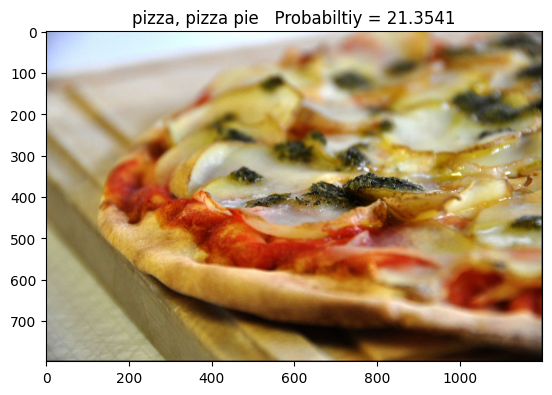

In [26]:
'''
Step - 1 : Download the pretrained Alexnet
'''

alexnet = models.alexnet(pretrained = True)


'''
Optional - Print out the structure of Alexnet
'''

# print(alexnet)


'''
Step - 2 : Always a good practice to preprocess the images(s)
'''

preprocessFn = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])])

'''
Step - 3 : Instantiate Alexnet in Eval Mode
'''

alexnet.eval()

'''
Step - 4 : Load a Test Image and Preprocess 
'''
path = "./Test-Images/pizza.jpg"
image = Image.open(path).convert('RGB')
inputVar =  Variable(preprocessFn(image).unsqueeze(0))

# if torch.cuda.is_available():
#     inputVar = inputVar.to('cuda')
#     alexnet.to('cuda')

'''
Step - 5 : Run the Image through Alexnet
'''
predictions = alexnet(inputVar)
print(predictions.shape)

'''
Step - 6 : Output the Top Probability
'''
probs = torch.max(predictions)
print(probs)

'''
Step - 7 : Out the Image with Label and Probability
'''

plt.title(f"{labels[predictions.argmax().item()]}   Probabiltiy = {probs.item():.4f}")
plt.imshow(image);


C:\Users\seanr\AppData\Local\Temp\ipykernel_19304\3452620670.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 8, i + 1)


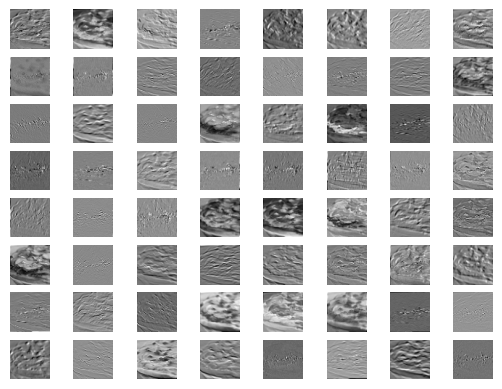

In [89]:
#Code to extract 1st Layer from Alexnet and Display shape

'''
Import the image and preprocess
'''
preprocessFn = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ColorJitter(.5, .5, .5),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])
                                 ])
                                 
path = "./Test-Images/pizza.jpg"
image_c = Image.open(path).convert('RGB')
iVar =  Variable(preprocessFn(image_c).unsqueeze(0))

# if torch.cuda.is_available():
#     iVar = inputVar.to('cuda')

'''
Extract the first Convolutional Layer
'''
feature_extraction = [child for child in alexnet.children()][0]
convolution_layer = feature_extraction[0]

'''
Run the image through this convolutional layer. Print out the shape and also the image representation.
'''
out = convolution_layer.forward(iVar).cpu()

'''
Note - The first Convolutional Layer extracts the outlines of the figure.
'''
plt.imshow(out.cpu()[0][0].detach().numpy())

'''
*********
Write the code that outputs a grid (8x8) of the 64 images you get as the output of the first convolutional layer
*******
'''
for i, o in enumerate(out[0]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(o.detach().numpy(), cmap="gray")
    plt.axis("off")



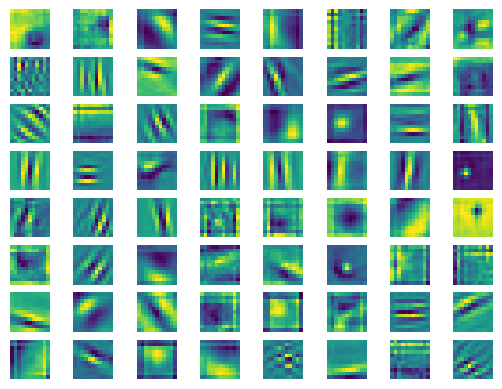

In [87]:
'''Now visualize the filters
* Look how I am extracting the weights of the 51th filter of the first channel 
and just extend it to create a grid plot of the 64 filters 
'''



for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(alexnet.features[0].weight.data[i,0,:,:])
    plt.axis("off")


In [134]:
'''Here you will feed to the network your own image. And output the top 5 probabilities of the predicted classes.
* Make sure you make some preprocessing to it, you can also try blurring the image and see what happens
* Make sure your image class corresponds to one of the 1000 classes of alexnet
'''
from statistics import mean 


path = "./Test-Images/computer2.png"
image_c = Image.open(path).convert('RGB')

transforms_lst = [
  transforms.ColorJitter(.5, .5, .5),
  transforms.RandomInvert(),
  transforms.RandomPerspective(),
  transforms.RandomAdjustSharpness(2),
  transforms.RandomAffine(45)
]
                                

def apply_transform(transform):
  processor = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transform,
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
  ])

  return Variable(processor(image_c).unsqueeze(0))

best = {}

for transform in transforms_lst:
  transformed = apply_transform(transforms_lst[0])

  predictions = alexnet(transformed)

  values, indexes = torch.topk(predictions, 5)
  for v, i in zip(values[0], indexes[0]):
    best.setdefault(labels[i], []).append(v.item())

  longest = max(len(v) for v in best.values())
  for v in best.values():
    if len(v) < longest:
      v.append(None)

# Prints in a latex format for easy copy-pasting into a tabular
print(f"Label & {' & '.join(str(t.__class__.__name__) for t in transforms_lst)}")
for key, value in best.items():
  print(f"{key:<30}& {' & '.join('-' if not v else format(v, '.2f') for v in value)} & {mean(v for v in value if v):.2f}\\\\")

Label & ColorJitter & RandomInvert & RandomPerspective & RandomAdjustSharpness & RandomAffine
desktop computer              & 19.39 & 17.02 & 16.98 & 15.75 & 16.21 & 17.07\\
modem                         & 14.30 & 13.86 & 12.92 & 13.59 & 12.71 & 13.48\\
notebook, notebook computer   & 13.30 & 12.68 & 11.78 & 12.39 & 11.27 & 12.29\\
radio, wireless               & 13.05 & - & - & - & - & 13.05\\
laptop, laptop computer       & 12.59 & 11.91 & 11.52 & 11.36 & 11.33 & 11.74\\
monitor                       & 11.46 & - & 11.52 & 11.28 & 11.61 & 11.47\\
